In [1]:
%matplotlib inline
#%matplotlib widget
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

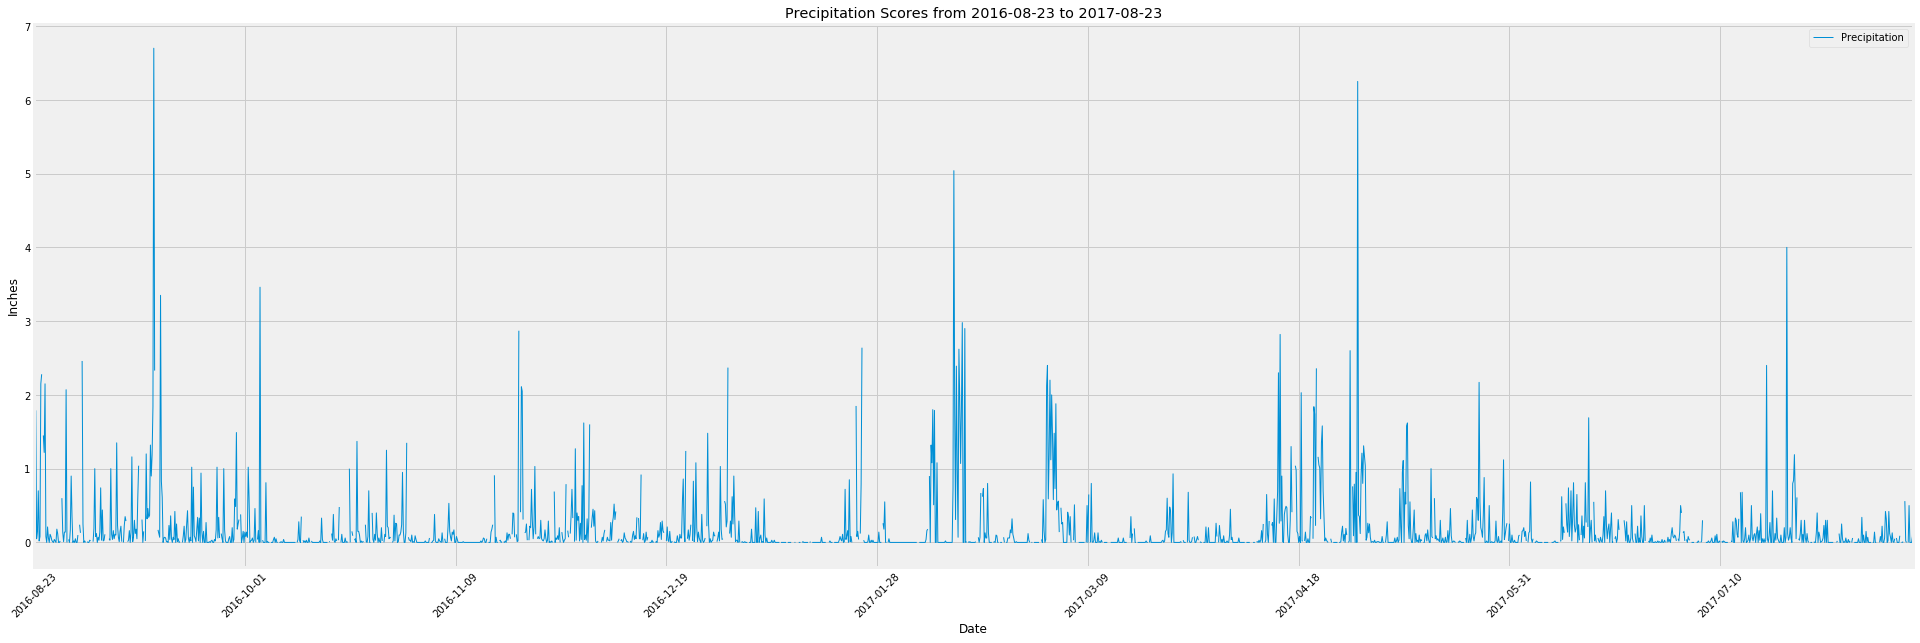

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

earliest_date =  dt.datetime.strptime(latest_date, "%Y-%m-%d") - dt.timedelta(days=365)

earliest_date = earliest_date.strftime("%Y-%m-%d")
# Perform a query to retrieve the data and precipitation scores
last_12_months = session.query(Measurement.date, Measurement.prcp).\
                 filter(Measurement.date <= latest_date,\
                        Measurement.date >= earliest_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
weather_df = pd.DataFrame(last_12_months)
weather_df = weather_df.set_index('date')

# Sort the dataframe by date
weather_df = weather_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
fig1, ax = plt.subplots()
ax = weather_df.plot(rot = 45, lw= '1', figsize=(30,10),\
                title = f"Precipitation Scores from {earliest_date} to {latest_date}", ax=ax)
#figure1.label()
ax.set_xlabel('Date')
ax.set_ylabel('Inches')
ax.legend(["Precipitation"])
#ax.set_xlim(['2016-08-23','2017-08-23'])
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
weather_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
#len(session.query(Station.name).group_by(Station.name).all()) alternative
len(session.query(Measurement.station).group_by(Measurement.station).all())

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.id).\
              label('Number_of_Stations')).group_by(Measurement.station).\
              order_by(text("Number_of_Stations DESC")).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = session.query(Measurement.station, func.count(Measurement.station).\
              label('Number_of_Stations')).group_by(Measurement.station).\
              order_by(text("Number_of_Stations DESC")).first()

#most_active_station = most_active_station[0]
sel = [Measurement.station,\
      func.min(Measurement.tobs),\
      func.max(Measurement.tobs),\
      func.avg(Measurement.tobs)]

session.query(*sel).filter(Measurement.station == most_active_station[0]).all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

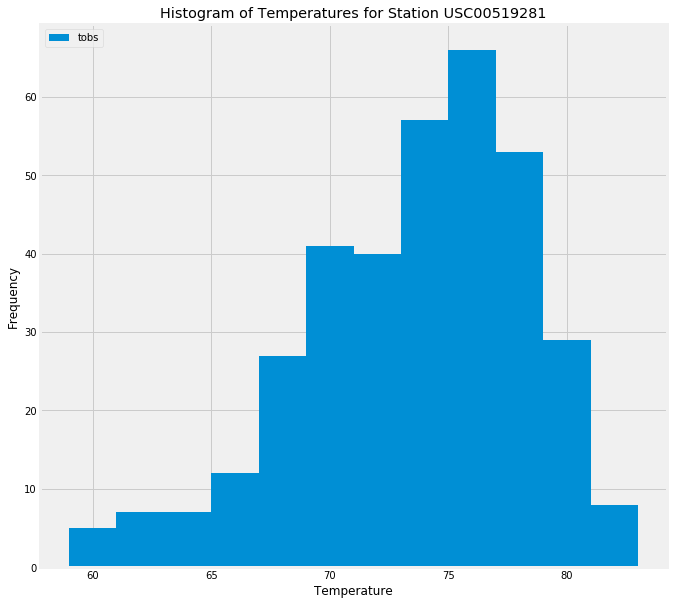

In [17]:
# Choose the station with the highest number of temperature observations.
tobs_obs_count = session.query(Measurement.station, func.count(Measurement.tobs).\
              label('Number_of_Obs')).group_by(Measurement.station).\
              order_by(text("Number_of_Obs DESC")).first()
station_max_obs = tobs_obs_count[0]
station_max_obs

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.tobs).\
                 filter(Measurement.date <= latest_date,\
                        Measurement.date >= earliest_date,
                       Measurement.station == station_max_obs).all()

temp_data = [temp[0] for temp in temp_data]
fig2, ax = plt.subplots(figsize=(10,10))
ax.hist(temp_data, bins=12, label='tobs')
plt.title(f"Histogram of Temperatures for Station {station_max_obs}")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(loc = 'upper left')
plt.show()

## Bonus Challenge Assignment

### Temparature Analysis I

In [18]:
from scipy import stats

In [19]:
June_avg_temps = session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date) == "06").\
                group_by(Measurement.station).all()
Dec_avg_temps = session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date) == "12").\
                group_by(Measurement.station).all()
June_avg_temps = [temp[0] for temp in June_avg_temps]
Dec_avg_temps = [temp[0] for temp in Dec_avg_temps]

In [21]:
stats.ttest_rel(June_avg_temps, Dec_avg_temps)

Ttest_relResult(statistic=6.95696617044294, pvalue=0.00011759380231523222)

A paired t-test was used as the samples come from the same population. The difference between the June temperatures and December temperatures is statistically significant as the p-value is less than 0.05.

### Temparatue Analysis II

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [131]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#Holiday dates are 2018-06-15 - 2018-06-25
sdate = dt.date(2017, 6, 15)
edate = dt.date(2017, 6, 25)

trip_data = calc_temps(sdate, edate)
trip_data = [stat for stat in trip_data[0]]
print(trip_data)

[71.0, 76.79411764705883, 82.0]


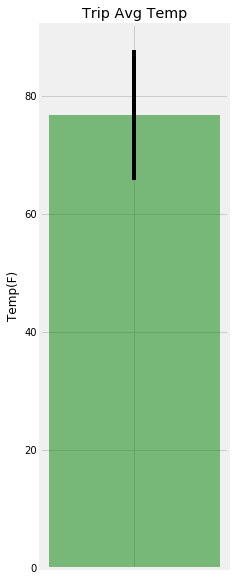

In [84]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig3, ax = plt.subplots(figsize=(3,10))
bars = ['']
y_pos = np.arange(len(bars))
peak_peak = trip_data[2] - trip_data[0]
ax.bar(y_pos, height = trip_data[1], width=0.01, yerr=[peak_peak], alpha = 0.5, color = 'g')
plt.ylabel('Temp(F)')
plt.xticks(y_pos, bars)
plt.title('Trip Avg Temp')
plt.show()

### Daily Rainfall Average

In [82]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [func.sum(Measurement.prcp).label('Total_Prcp'), Station.station, Station.name,\
       Station.latitude, Station.longitude, Station.elevation]

rainfall_data = session.query(*sel).filter(Measurement.station == Station.station).filter(Measurement.date >= '2017-06-15').\
            filter(Measurement.date <= '2017-06-25').\
            group_by(Station.station).\
            order_by(text('Total_Prcp DESC')).all()   

for record in rainfall_data:
    print(record)

(5.1, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
(1.75, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
(1.0900000000000003, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(0.88, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(0.13, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(0.060000000000000005, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
(0.0, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)


In [69]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [132]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
sdate = dt.date(2017, 6, 15)
edate = dt.date(2017, 6, 25)

# Use the start and end date to create a range of dates
diff = edate - sdate
diff = diff.days + 1

dates_list = []

for i in range(diff):
    day = sdate + dt.timedelta(days=i)
    dates_list.append(day)

m_d_string_list = []
# Stip off the year and save a list of %m-%d strings
for day in dates_list:
    
    day = day.strftime("%m-%d")
    
    m_d_string_list.append(day)
    
# Loop through the list of %m-%d strings and calculate the normals for each date
normals_list = []
for day in m_d_string_list:
    normal = daily_normals(day)
    normals_list.append(normal[0])

In [133]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals_list, index=dates_list, columns=['Min', 'Avg', ' Max'])

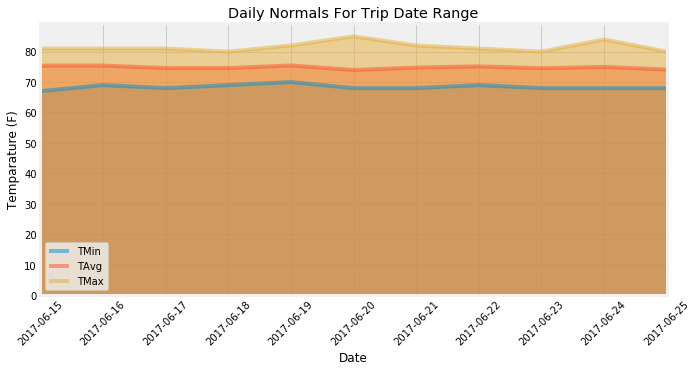

In [136]:
# Plot the daily normals as an area plot with `stacked=False`
#fig4, ax = plt.subplots(figsize=(5,10))
ax = df.plot.area(rot = 45, alpha = 0.5, stacked=False, figsize=(10,5))
ax.set_xlabel('Date')
ax.set_ylabel('Temparature (F)')
ax.legend(['TMin', 'TAvg', 'TMax'])
ax.set_title('Daily Normals For Trip Date Range')
plt.show()